Run in region ```[1000000-10000000]``` uising four clusters


In [1]:
import sys

In [2]:
sys.path.append("../")

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from helpers import read_configuration_file
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType

In [5]:
# let's plot the clusters and see what we have
def plot_cluster(filename, nbins=35, kde=False, rug=True):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        cluster_0_counts = [float(item) for item in arraystr]
        sns.distplot(cluster_0_counts, bins=nbins, kde=kde, rug=rug)
        plt.show()

In [6]:
def print_hmm_info(hmm_file):
    with open(hmm_file) as json_file:
        hmm_json_map = json.load(json_file)
        hmm_json_map = json.loads(hmm_json_map)
        
        print("Start state: ")
        print("Distribution: ", hmm_json_map["start"]["distribution"])
        print("End state:")
        print("Distribution: ", hmm_json_map["end"]["distribution"])

        states = hmm_json_map["states"]
    
        for state in states:
            print("====================================================")
            print("State: ", state["name"])
            print("State weight: ", state["weight"])
            distribution = state["distribution"]

            if distribution is not None:

                print("Distribution: ", distribution["class"])

                if distribution["class"] == "Distribution":
                    print("Distribution name: ", distribution["name"])

                    if distribution["name"] == "IndependentComponentsDistribution":
                        distributions = distribution["parameters"][0]
                        for dist in distributions:

                            if dist["class"] == "GeneralMixtureModel":
                                gmm_distributions = dist["distributions"]

                                for gmm_dist in gmm_distributions:
                                    print("Distribution name: ", gmm_dist["name"])
                                    print("Distribution params: ", gmm_dist["parameters"])
                                print("Weights: ", dist["weights"])
                            else:
                                print("Distribution name: ", dist["name"])
                                print("Distribution params: ", dist["parameters"])
                                print("Weights: ", distribution["parameters"][1])
                elif distribution["class"] == "GeneralMixtureModel":
                    distributions = distribution["distributions"]

                    for dist in distributions:
                        print("Distribution name: ", dist["name"])
                        print("Distribution params: ", dist["parameters"])
                    print("Weights: ", distribution["weights"])

In [7]:
sns.set(color_codes=True)
%matplotlib inline

In [8]:
ffile = "../../"
cluster_files=[(ffile +  "cluster_0_wga_w_mean.txt", ffile +  "cluster_0_no_wga_w_mean.txt"),
               (ffile +  "cluster_1_wga_w_mean.txt", ffile +  "cluster_1_no_wga_w_mean.txt"),
               (ffile +  "cluster_2_wga_w_mean.txt", ffile +  "cluster_2_no_wga_w_mean.txt"),
               (ffile +  "cluster_3_wga_w_mean.txt", ffile +  "cluster_3_no_wga_w_mean.txt")]

Cluster:  0


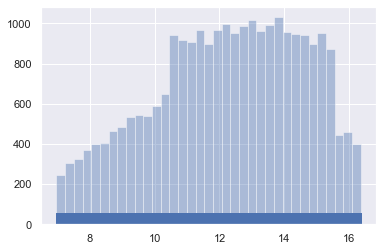

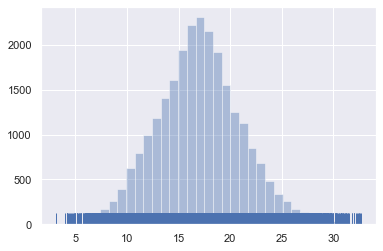

Cluster:  1


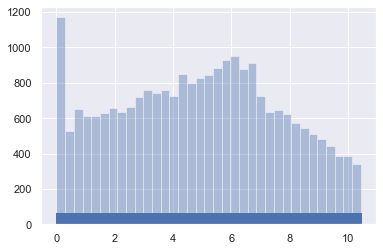

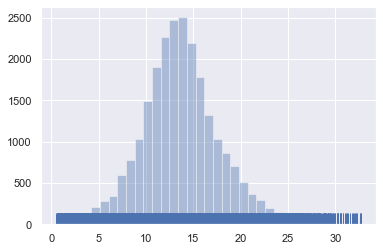

Cluster:  2


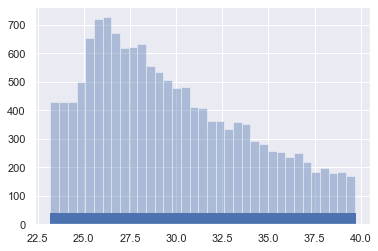

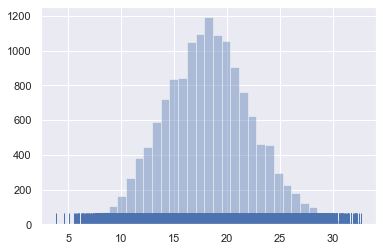

Cluster:  3


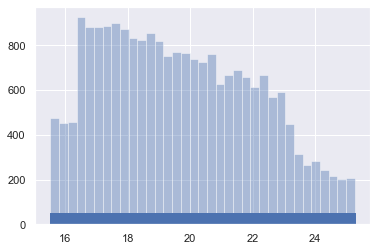

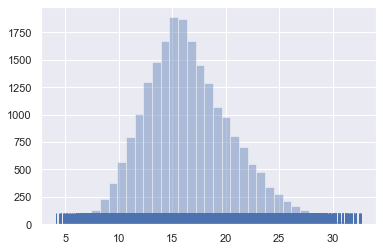

In [9]:
for i, files in enumerate(cluster_files):
    print("Cluster: ", i)
    plot_cluster(filename=files[0])
    plot_cluster(filename=files[1])

In [10]:
# load the configuration
configuration=read_configuration_file("../config.json")

In [11]:
# set up the configuration for the HMM training
clusters_config = configuration["clusters"]

In [12]:
print(clusters_config)

{'cluster_0': {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'normal', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_1': {'filename': '/home/a/ag568/cluster_1.txt', 'state': 'tuf', 'distributions': {'wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}, 'no_wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}}}}


In [13]:
# which cluster is normal
cluster_0 = clusters_config['cluster_0']


In [14]:
# set the filename and the distribution
cluster_0['filename']="/home/a/ag568/cluster_0.txt"
cluster_0['state']="one_copy_delete"
cluster_0['distributions']['wga']['type'] = 'distribution'
cluster_0['distributions']['wga']['name'] = 'uniform'
cluster_0['distributions']['wga']['parameters'] = [0.0, 16.0]


In [15]:
# which cluster is TUF?
cluster_1 = clusters_config['cluster_1']

In [16]:
# set the filename and the distribution
cluster_1['filename']="/home/a/ag568/cluster_1.txt"
cluster_1['state']="tuf"
cluster_1['distributions']['wga']['type'] = 'gmm'
cluster_1['distributions']['wga']['uniform']['params'] = [2.0, 8.0]
cluster_1['distributions']['no_wga'] = {'type': 'distribution', 'name':'normal'}

In [17]:
# add one more cluster
extra_cluster = {'filename': '/home/a/ag568/cluster_2.txt', 'state': 'insertion',
                'distributions':{'wga':{'type':'distribution', 'name': 'normal'},
                                 'no_wga':{'type':'distribution', 'name': 'normal'}}}



In [18]:
clusters_config['cluster_2'] = extra_cluster


In [19]:
# add one more cluster
extra_cluster = {'filename': '/home/a/ag568/cluster_3.txt', 'state': 'normal',
                'distributions':{'wga':{'type':'distribution', 'name': 'normal'},
                                 'no_wga':{'type':'distribution', 'name': 'normal'}}}

In [20]:
clusters_config['cluster_3'] = extra_cluster

In [21]:
print(clusters_config)


{'cluster_0': {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'one_copy_delete', 'distributions': {'wga': {'type': 'distribution', 'name': 'uniform', 'parameters': [0.0, 16.0]}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_1': {'filename': '/home/a/ag568/cluster_1.txt', 'state': 'tuf', 'distributions': {'wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_2': {'filename': '/home/a/ag568/cluster_2.txt', 'state': 'insertion', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_3': {'filename': '/home/a/ag568/cluster_3.txt', 'state': 'normal', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}}


In [22]:
hmm_states = configuration["HMM"]["states"]

In [23]:
print(hmm_states)

{'tuf': {'start_prob': 0.48}, 'normal': {'start_prob': 0.48}, 'gap_state': {'start_prob': 0.04}}


In [24]:
hmm_states['tuf']['start_prob'] = 0.025
hmm_states['normal']['start_prob'] = 0.9
hmm_states['gap_state']['start_prob'] = 0.025
hmm_states['one_copy_delete'] = { "start_prob":0.025}
hmm_states['insertion'] = { "start_prob":0.025}

In [25]:
print(hmm_states)

{'tuf': {'start_prob': 0.025}, 'normal': {'start_prob': 0.9}, 'gap_state': {'start_prob': 0.025}, 'one_copy_delete': {'start_prob': 0.025}, 'insertion': {'start_prob': 0.025}}


In [26]:
# we also need to add the extra transition
hmm_transitions =  configuration["HMM"]["transitions"]

In [27]:

print(hmm_transitions)

{'tuf-tuf': 0.95, 'normal-normal': 0.95, 'tuf-normal': 0.05, 'normal-tuf': 0.05, 'gap_state-gap_state': 0.95, 'gap_state-tuf': 0.05, 'tuf-gap_state': 0.05, 'normal-gap_state': 0.05, 'gap_state-normal': 0.05}


In [28]:
hmm_transitions["one_copy_delete-one_copy_delete"] = 0.95
hmm_transitions["one_copy_delete-normal"] = 0.05
hmm_transitions["normal-one_copy_delete"] = 0.05
hmm_transitions["tuf-one_copy_delete"] = 0.05
hmm_transitions["one_copy_delete-tuf"] = 0.05
hmm_transitions["gap_state-one_copy_delete"] = 0.05
hmm_transitions["one_copy_delete-gap_state"] = 0.05
hmm_transitions["one_copy_delete-insertion"] = 0.05
hmm_transitions["insertion-one_copy_delete"] = 0.05

hmm_transitions["insertion-insertion"] = 0.95
hmm_transitions["insertion-normal"] = 0.05
hmm_transitions["normal-insertion"] = 0.05
hmm_transitions["tuf-insertion"] = 0.05
hmm_transitions["insertion-tuf"] = 0.05
hmm_transitions["gap_state-insertion"] = 0.05
hmm_transitions["insertion-gap_state"] = 0.05


In [29]:
print(hmm_transitions)

{'tuf-tuf': 0.95, 'normal-normal': 0.95, 'tuf-normal': 0.05, 'normal-tuf': 0.05, 'gap_state-gap_state': 0.95, 'gap_state-tuf': 0.05, 'tuf-gap_state': 0.05, 'normal-gap_state': 0.05, 'gap_state-normal': 0.05, 'one_copy_delete-one_copy_delete': 0.95, 'one_copy_delete-normal': 0.05, 'normal-one_copy_delete': 0.05, 'tuf-one_copy_delete': 0.05, 'one_copy_delete-tuf': 0.05, 'gap_state-one_copy_delete': 0.05, 'one_copy_delete-gap_state': 0.05, 'one_copy_delete-insertion': 0.05, 'insertion-one_copy_delete': 0.05, 'insertion-insertion': 0.95, 'insertion-normal': 0.05, 'normal-insertion': 0.05, 'tuf-insertion': 0.05, 'insertion-tuf': 0.05, 'gap_state-insertion': 0.05, 'insertion-gap_state': 0.05}


In [30]:
print(configuration)

{'regions': {'start': [1000000], 'end': [10000000]}, 'regions_files': ['/home/a/ag568/region_0.txt'], 'chromosome': 'chr1', 'reference_file': {'filename': '/scratch/spectre/a/ag568/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna'}, 'no_wga_file': {'filename': '/scratch/spectre/a/ag568/m585_verysensitive_trim_sorted.bam'}, 'test_file': {'filename': '/scratch/spectre/a/ag568/m605_verysensitive_trim_sorted.bam'}, 'debug': {'log_bam_for_debug': False}, 'window_size': 100, 'fill_missing_window_data': False, 'fill_missing_window_data_factor': 0, 'quality_threshold': None, 'save_windows': False, 'remove_windows_with_N': False, 'mark_N_windows': True, 'mark_for_N_windows': -999.0, 'n_windows_dist': {'name': 'uniform', 'config': {'parameters': [-999.5, -998.5]}}, 'windows_filename': 'hmm_windows.json', 'check_windowing_sanity': True, 'outlier_remove': {'name': 'zscore', 'config': {'sigma_factor': 2}}, 'label_clusters': True, 'labeler': {'name': 'mean_diff', 'tuf_mean_min': 1.5, 'tuf_mean_max': 

In [31]:
# now we can train
main(configuration=configuration)

INFO: Set up logger
INFO: Done...
INFO: Load regions...
INFO: Check window sanity for region 0
INFO: Done...
INFO: Done. Execution time 105.61832744399726 secs
INFO: Load clusters
INFO: Done. Execution time 0.009100392999243923 secs
INFO: Build cluster densities
INFO: Cluster state: one_copy_delete
INFO: Cluster name: cluster_0
INFO: Cluster state: tuf
INFO: Cluster name: cluster_1
INFO: Cluster state: insertion
INFO: Cluster name: cluster_2
INFO: Cluster state: normal
INFO: Cluster name: cluster_3
INFO: Done. Execution time 0.0005719400069210678 secs
INFO: Star HMM initialization...
INFO: State: GAP_STATE
INFO: Distributions: {'class': 'Distribution', 'name': 'IndependentComponentsDistribution', 'parameters': [[{'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}, {'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}], [1.0, 1.0]], 'frozen': False}
INFO: State: one_copy_delete
INFO

In [42]:
# load the hmm

try:
    hmm_file = "/home/a/ag568/HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
except FileNotFoundError as e:
    hmm_file = "HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
   

Start state: 
Distribution:  None
End state:
Distribution:  None
State:  GAP_STATE
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  UniformDistribution
Distribution params:  [-999.3007669620789, -998.6992330379212]
Weights:  [1.0, 1.0]
Distribution name:  UniformDistribution
Distribution params:  [-999.3007669620789, -998.6992330379212]
Weights:  [1.0, 1.0]
State:  insertion
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  NormalDistribution
Distribution params:  [30.935062227486153, 7.397654490693314]
Weights:  [1.0, 1.0]
Distribution name:  NormalDistribution
Distribution params:  [19.009967406625165, 8.145778145641344]
Weights:  [1.0, 1.0]
State:  normal
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  NormalDistribution
Distribution params:  [19.404889943555947, 3.01846

In [43]:
# this is the model we trained
hmm = build_hmm(hmm_file)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


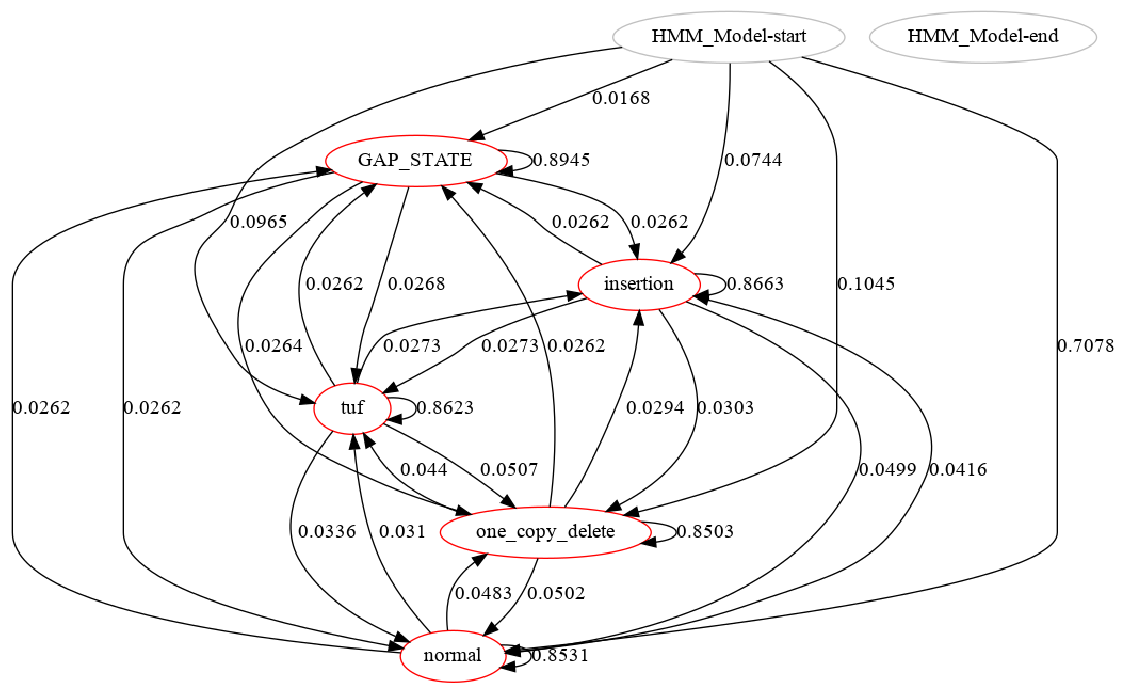

In [44]:
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm.plot()
plt.show()

if we don't want to allow updates to the model, comment this out

In [35]:

#hmm.freeze()


The regions are stored in the ```regions_files``` entry. We can edit this list and add/subtrat accordingly.
Here we load all the regions used in fitting the HMM.

In [45]:
regions = load_regions(configuration=configuration)

INFO: Load regions...
INFO: Check window sanity for region 0
INFO: Done...
INFO: Done. Execution time 94.28158537800482 secs


In [46]:
print("Number or regions: {0}".format(len(regions)))

Number or regions: 1


Construct sequences of size ```size``` from the first region. The ```window_type``` indicates which of the two samples to use. Valid options are ```WindowType.WGA```, ```WindowType.NO_WGA``` and ```WindowType.BOTH```.
```n_seqs``` indicates how many sequences to extract. If set to ```None``` the whole region is partitioned into sequences with size ```size```.  

In [47]:
n_seqs=10
sequences = regions[0].get_region_as_sequences(size=10, window_type=WindowType.BOTH, n_seqs=n_seqs)

For each of the sequences, run the Viterbi algorithm on the sequence given the model. This finds the ML path of hidden states given the sequence. Returns a tuple of the log probability of the ML path, or (-inf, None) if the sequence is impossible under the model. 
If a path is returned, it is a list of tuples of the form (sequence index, state object).

In [48]:

for seq in sequences:
    
    print("Sequence size: ", len(seq))
    viterbi_path = hmm.viterbi(seq)
    
    print("Log-probability of ML Viterbi path: ", viterbi_path[0])

    if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        for item in range(len(seq)):
            print("sequnce item: {0} state {1}".format(seq[item], viterbi_path[1][item+1][1].name))


Sequence size:  10
Log-probability of ML Viterbi path:  -59.41974847025822
Viterbi path length:  11
sequnce item: (5.44, 5.35) state tuf
sequnce item: (3.42, 7.35) state tuf
sequnce item: (6.56, 8.82) state tuf
sequnce item: (2.91, 10.73) state tuf
sequnce item: (4.45, 19.26) state tuf
sequnce item: (4.27, 10.31) state tuf
sequnce item: (3.66, 12.84) state tuf
sequnce item: (7.46, 14.77) state tuf
sequnce item: (5.3, 13.72) state tuf
sequnce item: (5.27, 13.44) state tuf
Sequence size:  10
Log-probability of ML Viterbi path:  -56.305083545693314
Viterbi path length:  11
sequnce item: (6.34, 17.85) state tuf
sequnce item: (2.96, 13.49) state tuf
sequnce item: (4.01, 14.47) state tuf
sequnce item: (3.63, 11.73) state tuf
sequnce item: (3.36, 11.01) state tuf
sequnce item: (3.52, 13.64) state tuf
sequnce item: (6.98, 6.41) state tuf
sequnce item: (7.12, 11.44) state tuf
sequnce item: (8.78, 11.82) state tuf
sequnce item: (6.7, 10.78) state tuf
Sequence size:  10
Log-probability of ML Vite

Calculate the probability of a given sequence coming from the model we trained. This uses the forward algorithm internally

In [49]:
p_d_given_m = hmm.log_probability(sequence=sequences[0])
print("P(D|M): ", p_d_given_m)

P(D|M):  -59.33620676223627


The raw normalized probability matrices can be called using

In [50]:
hmm.predict_proba(sequences[0])

array([[0.00000000e+00, 8.96422446e-05, 2.27402912e-07, 5.08246366e-04,
        9.99401884e-01],
       [0.00000000e+00, 6.66040467e-07, 1.22677723e-10, 1.12679115e-04,
        9.99886655e-01],
       [0.00000000e+00, 1.68342949e-06, 3.38172915e-08, 3.66738189e-04,
        9.99631545e-01],
       [0.00000000e+00, 2.76019341e-07, 3.00954564e-10, 3.24483164e-03,
        9.96754892e-01],
       [0.00000000e+00, 2.80171373e-06, 5.10762000e-08, 1.86630944e-02,
        9.81334053e-01],
       [0.00000000e+00, 5.34316872e-07, 2.60224047e-09, 6.05435133e-03,
        9.93945112e-01],
       [0.00000000e+00, 3.44174197e-07, 2.35835815e-09, 1.10292684e-02,
        9.88970385e-01],
       [0.00000000e+00, 2.89880988e-06, 1.69010673e-06, 2.48288061e-02,
        9.75166605e-01],
       [0.00000000e+00, 8.91994849e-07, 5.41317844e-08, 3.37202237e-02,
        9.66278830e-01],
       [0.00000000e+00, 1.75643820e-05, 7.53194169e-07, 5.46631276e-02,
        9.45318555e-01]])